In [2]:
from __future__ import print_function, division
%load_ext autoreload

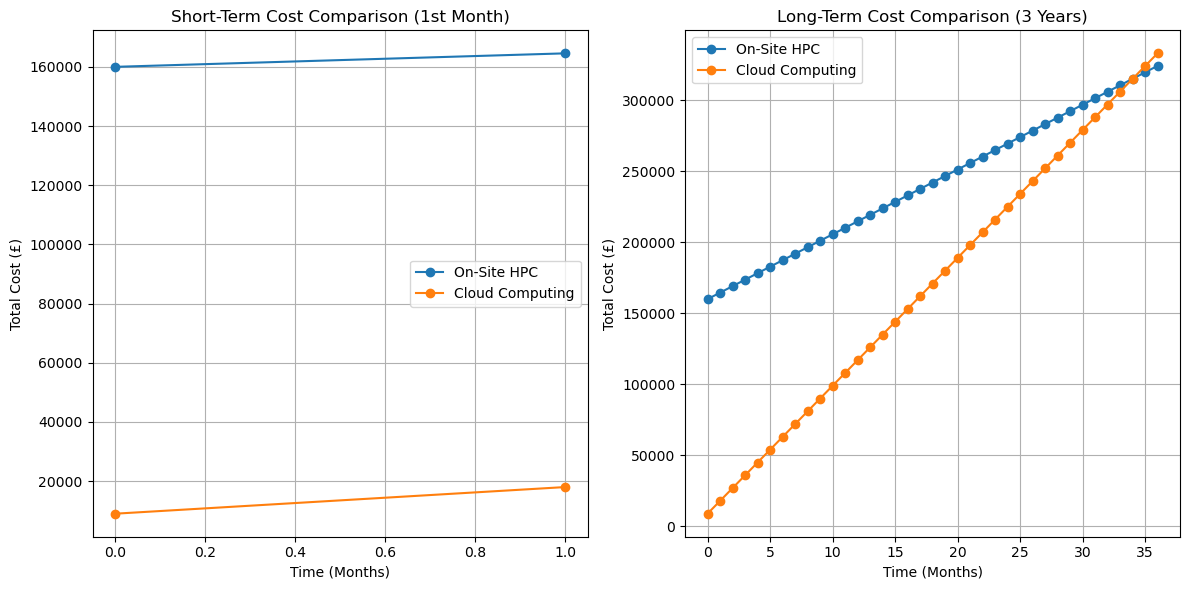

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Define the costs for On-Site HPC and Cloud Computing
onsite_costs = {
    'initial_investment': 32000 + 8000 + 120000,  # Servers + Networking + Storage
    'monthly_energy': 205,
    'monthly_depreciation': (32000 / 36) + (8000 / 60) + (120000 / 36),  # Servers + Networking + Storage
}

cloud_costs = {
    'cpu_time': 6750,
    'storage': 2250
}

# Calculate the total costs over time
time_frame = np.arange(0, 37)  # 36 months + initial month 0
onsite_total_costs = [onsite_costs['initial_investment']] + list(onsite_costs['monthly_energy'] + onsite_costs['monthly_depreciation'] for _ in time_frame[1:])
cloud_total_costs = [cloud_costs['cpu_time'] + cloud_costs['storage']] * len(time_frame)

# Convert total costs to cumulative costs over time
onsite_cumulative_costs = np.cumsum(onsite_total_costs)
cloud_cumulative_costs = np.cumsum(cloud_total_costs)

# Create time-series plots
plt.figure(figsize=(12, 6))

# Short-term costs (1 month)
plt.subplot(1, 2, 1)
plt.plot(time_frame[:2], onsite_cumulative_costs[:2], label='On-Site HPC', marker='o')
plt.plot(time_frame[:2], cloud_cumulative_costs[:2], label='Cloud Computing', marker='o')
plt.title('Short-Term Cost Comparison (1st Month)')
plt.xlabel('Time (Months)')
plt.ylabel('Total Cost (£)')
plt.legend()
plt.grid(True)

# Long-term costs (36 months)
plt.subplot(1, 2, 2)
plt.plot(time_frame, onsite_cumulative_costs, label='On-Site HPC', marker='o')
plt.plot(time_frame, cloud_cumulative_costs, label='Cloud Computing', marker='o')
plt.title('Long-Term Cost Comparison (3 Years)')
plt.xlabel('Time (Months)')
plt.ylabel('Total Cost (£)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
# Calculate the monthly energy cost for the firm's on-site HPC

# Assumptions
power_usage_per_server_watt = 500  # in watts
power_usage_per_server_kw = power_usage_per_server_watt / 1000  # convert to kW
cost_per_kwh = 0.27  # in GBP
hours_per_month = 15_000  # CPU hours per core per month
cores = 64  # number of cores

# Total kW used by one server in a month
total_kw_per_server = power_usage_per_server_kw * hours_per_month

# Total kW for all cores (assuming each core can run on one server)
total_kw_all_cores = total_kw_per_server * (cores / 64)  # Adjusted for 64 cores/server

# Total energy cost per month for all servers
total_energy_cost_per_month = total_kw_all_cores * cost_per_kwh

total_energy_cost_per_month

2025.0000000000002

In [3]:
%autoreload 2

import copy, math, os, pickle, time, pandas as pd, numpy as np, scipy.stats as ss

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score

import torch, torch.utils.data as utils, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable
from torch.nn.parameter import Parameter


from src.model.mmd_grud_utils import *
from utils.eda_functions import (load_from_pickle, save_to_pickle)
from config import *

In [4]:
vitals_train = load_from_pickle('../data/resampled/vitals_train.pkl')
vitals_train.head()

LEVEL2                                 anion gap            \
Aggregation Function                        mask      mean   
subject_id hadm_id icustay_id hours_in                       
3          145834  211552     0              0.0  0.216667   
                              1              0.0  0.216667   
                              2              1.0  0.511111   
                              3              0.0  0.511111   
                              4              0.0  0.511111   

LEVEL2                                                     bicarbonate        \
Aggregation Function                   time_since_measured        mask  mean   
subject_id hadm_id icustay_id hours_in                                         
3          145834  211552     0                  -1.052080         1.0  0.14   
                              1                  -1.052080         0.0  0.14   
                              2                  -1.052080         1.0  0.16   
                              3                  -0.929885         0.0  0.16   
                              4                  -0.807689         0.0  0.16   

LEVEL2                                                      \
Aggregation Function                   time_since_measured   
subject_id hadm_id icustay_id hours_in                       
3          145834  211552     0                  -1.120341   
                              1                  -0.977616   
                              2                  -1.120341   
                              3                  -0.977616   
                              4                  -0.834891   

LEVEL2                                 blood urea nitrogen         \
Aggregation Function                                  mask   mean   
subject_id hadm_id icustay_id hours_in                              
3          145834  211552     0                        0.0  0.142   
                              1                        0.0  0.142   
                              2                        1.0  0.112   
                              3                        0.0  0.112   
                              4                        0.0  0.112   

LEVEL2                                                     calcium  ...  \
Aggregation Function                   time_since_measured    mask  ...   
subject_id hadm_id icustay_id hours_in                              ...   
3          145834  211552     0                  -1.138992     0.0  ...   
                              1                  -1.138992     0.0  ...   
                              2                  -1.138992     1.0  ...   
                              3                  -0.990705     0.0  ...   
                              4                  -0.842418     0.0  ...   

LEVEL2                                 systolic blood pressure temperature  \
Aggregation Function                       time_since_measured        mask   
subject_id hadm_id icustay_id hours_in                                       
3          145834  211552     0                      -0.146685         0.0   
                              1                      -0.146685         0.0   
                              2                      -0.146685         1.0   
                              3                      -0.146685         1.0   
                              4                      -0.146685         1.0   

LEVEL2                                                                \
Aggregation Function                        mean time_since_measured   
subject_id hadm_id icustay_id hours_in                                 
3          145834  211552     0         0.682345           -0.457508   
                              1         0.682345           -0.457508   
                              2         0.594749           -0.457508   
                              3         0.585617           -0.457508   
                              4         0.626714           -0.457508   

LEVEL2   

In [8]:
sample1 = vitals_train[vitals_train.index.get_level_values('subject_id') == 3]
save_to_pickle(sample1, '../data/resampled/sample1.pkl')

In [13]:
sample1.columns.get_level_values(1)

Index(['mask', 'mean', 'time_since_measured', 'mask', 'mean',
       'time_since_measured', 'mask', 'mean', 'time_since_measured', 'mask',
       ...
       'time_since_measured', 'mask', 'mean', 'time_since_measured', 'mask',
       'mean', 'time_since_measured', 'mask', 'mean', 'time_since_measured'],
      dtype='object', name='Aggregation Function', length=117)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
BLINDED = False
RANDOM = 0

In [8]:
RESAMPLED_DIR = '../data/resampled/'

In [9]:
X_train = load_from_pickle(os.path.join(RESAMPLED_DIR, 'vitals_train.pkl'))
X_dev = load_from_pickle(os.path.join(RESAMPLED_DIR, 'vitals_dev.pkl'))
X_test = load_from_pickle(os.path.join(RESAMPLED_DIR, 'vitals_test.pkl'))

Ys_train = load_from_pickle(os.path.join(RESAMPLED_DIR, 'Ys_train.pkl'))
Ys_dev = load_from_pickle(os.path.join(RESAMPLED_DIR, 'Ys_dev.pkl'))
Ys_test = load_from_pickle(os.path.join(RESAMPLED_DIR, 'Ys_test.pkl'))

In [ ]:
# X_flat = X_train.reset_index()
# X_flat.columns = X_flat.columns.droplevel(-1)
# Y_flat = Ys_train.reset_index()
# expanded_Y = pd.merge(X_flat, Y_flat, on=['subject_id', 'hadm_id', 'icustay_id'], how='left')
# Y_train = expanded_Y[['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'mort_hosp']]
# Y_train.set_index(['subject_id', 'hadm_id', 'icustay_id', 'hours_in'], inplace=True)
# 
# X_flat = X_dev.reset_index()
# X_flat.columns = X_flat.columns.droplevel(-1)
# Y_flat = Ys_dev.reset_index()
# expanded_Y = pd.merge(X_flat, Y_flat, on=['subject_id', 'hadm_id', 'icustay_id'], how='left')
# Y_dev = expanded_Y[['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'mort_hosp']]
# Y_dev.set_index(['subject_id', 'hadm_id', 'icustay_id', 'hours_in'], inplace=True)
# 
# X_flat = X_test.reset_index()
# X_flat.columns = X_flat.columns.droplevel(-1)
# Y_flat = Ys_test.reset_index()
# expanded_Y = pd.merge(X_flat, Y_flat, on=['subject_id', 'hadm_id', 'icustay_id'], how='left')
# Y_test = expanded_Y[['subject_id', 'hadm_id', 'icustay_id', 'hours_in', 'mort_hosp']]
# Y_test.set_index(['subject_id', 'hadm_id', 'icustay_id', 'hours_in'], inplace=True)

In [ ]:
# del Ys_train, Ys_dev, Ys_test, expanded_Y, X_flat, Y_flat

In [ ]:
# all_cols = []
# for i, col in enumerate(X_train.columns):
#     if col[0] not in all_cols:
#         all_cols.append(col[0])
#         print(col[0])

In [10]:
GAP_TIME          = 0  # In hours
WINDOW_SIZE       = 48 # In hours
SEED              = 69
ID_COLS           = ['subject_id', 'hadm_id', 'icustay_id']
GPU               = '2'

# os.environ['CUDA_VISIBLE_DEVICES'] = GPU
np.random.seed(SEED)
torch.manual_seed(SEED)

In [11]:
class DictDist():
    def __init__(self, dict_of_rvs): self.dict_of_rvs = dict_of_rvs
    def rvs(self, n):
        a = {k: v.rvs(n) for k, v in self.dict_of_rvs.items()}
        out = []
        for i in range(n): out.append({k: vs[i] for k, vs in a.items()})
        return out

class Choice():
    def __init__(self, options): self.options = options
    def rvs(self, n): return [self.options[i] for i in ss.randint(0, len(self.options)).rvs(n)]

### Task Prediction

#### Hyperparameters

In [16]:
N = 10

# GRU_D_dist = DictDist({
#     'cell_size': ss.randint(50, 75),
#     'hidden_size': ss.randint(65, 95),
#     'learning_rate': ss.uniform(2e-3, 1e-1),
#     'num_epochs': ss.randint(15, 150),
#     'patience': ss.randint(3, 7),
#     'batch_size': ss.randint(35, 65),
#     'early_stop_frac': ss.uniform(0.05, 0.1),
#     'seed': ss.randint(1, 10000),
# })

EARLY_STOP_FRAC = 0.05
SEED = 69

GRU_D_dist = DictDist({
    # 'cell_size': ss.randint(50, 75),
    'hidden_size': ss.randint(65, 95),
    'learning_rate': ss.loguniform(1e-4, 1e-1),
    'num_epochs': ss.randint(15, 150),
    'patience': ss.randint(3, 20),
    'batch_size': ss.randint(35, 65),
    # 'early_stop_frac': 0.1,  # Or any specific value or narrow range
    # 'seed': 69,  # Or any fixed seed value
    # 'grad_clip_value': ss.uniform(0.5, 1.0)
})

np.random.seed(SEED)
GRU_D_hyperparams_list = GRU_D_dist.rvs(N)

# with open('../src/model/baselines_gru-d.pkl', mode='rb') as f: results = pickle.load(f)

In [24]:
GRU_D_hyperparams_list = [
    {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 100, 'patience': 20, 'batch_size': 32},
    {'hidden_size': 64, 'learning_rate': 0.0001, 'num_epochs': 100, 'patience': 20, 'batch_size': 64},
    {'hidden_size': 64, 'learning_rate': 0.0005, 'num_epochs': 100, 'patience': 10, 'batch_size': 64},
    {'hidden_size': 128, 'learning_rate': 0.0005, 'num_epochs': 100, 'patience': 15, 'batch_size': 32},
    {'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 100, 'patience': 15, 'batch_size': 128},
    {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 100, 'patience': 10, 'batch_size': 64},
    {'hidden_size': 128, 'learning_rate': 0.001, 'num_epochs': 100, 'patience': 10, 'batch_size': 32},
    {'hidden_size': 32, 'learning_rate': 0.001, 'num_epochs': 100, 'patience': 15, 'batch_size': 128},
    {'hidden_size': 64, 'learning_rate': 0.001, 'num_epochs': 100, 'patience': 10, 'batch_size': 64},
    {'hidden_size': 32, 'learning_rate': 0.01, 'num_epochs': 100, 'patience': 5, 'batch_size': 128}
]

In [3]:
from itertools import product

# Define the parameter grid
hidden_sizes = [32, 64, 128]
learning_rates = [0.0001, 0.0005, 0.001, 0.01]
batch_sizes = [32, 64, 128]

# Placeholder for storing the results
grid_search_results = []

# The fixed number of epochs for training
num_epochs = 100
patience = 10

# Iterate over all combinations of hyperparameters
for learning_rate, hidden_size, batch_size in product(hidden_sizes, learning_rates, batch_sizes):

    grid_search_results.append({
        'hidden_size': hidden_size,
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'patience': patience,
        'num_epochs': num_epochs
    })

In [4]:
len(grid_search_results)

36

In [25]:
results = {}

#### GRU-D

In [26]:
from src.model.mmd_grud_utils import *

In [ ]:
# hyperparams = {'cell_size': 72,
#  'hidden_size': 128,
#  'learning_rate': 0.0001,
#  'num_epochs': 20,
#  'patience': 10,
#  'batch_size': 64}

In [ ]:
model_name       = 'GRU-D'
tasks             = ['mort_hosp']
hyperparams_list = GRU_D_hyperparams_list
RERUN            = False

if model_name not in results: results[model_name] = {}

# for t in tasks:         # Edit - DR
#     if t not in results[model_name]: results[model_name][t] = {}
t = 'mort_hosp'
if t not in results[model_name]: results[model_name][t] = {}
    # for n, X_train, X_dev, X_test in (('full_X', X_train, X_dev, X_test),):  # Edit - DR
n, X_train, X_dev, X_test = ('full_X', X_train, X_dev, X_test)
print("Running model %s on target %s with representation %s" % (model_name, t, n))
X_mean = np.nanmean(
    to_3D_tensor(
        X_train.loc[:, pd.IndexSlice[:, 'mean']] *
        np.where((X_train.loc[:, pd.IndexSlice[:, 'mask']] == 1).values, 1, np.NaN)
    ),
    axis=0, keepdims=True
).transpose([0, 2, 1])
base_params = {'X_mean': X_mean, 'output_last': True, 'input_size': X_mean.shape[2]}

if n in results[model_name][t]:
    if not RERUN:
        print("Final results for model %s on target %s with representation %s" % (model_name, t, n))
        print(results[model_name][t][n])
        # continue  # Edit - DR
    best_s, best_hyperparams = results[model_name][t][n][-1], results[model_name][t][n][1]
    print("Loading best hyperparams", best_hyperparams)
else:
    best_s, best_hyperparams = -np.Inf, None
    for i, hyperparams in enumerate(hyperparams_list):
        print("On sample %d / %d (hyperparams = %s)" % (i+1, len(hyperparams_list), repr((hyperparams))))

        # early_stop_frac,batch_size,seed = [hyperparams[k] for k in ('early_stop_frac','batch_size','seed')]    # Edit - DR
        batch_size = hyperparams['batch_size']

        np.random.seed(SEED)
        all_train_subjects = list(
            np.random.permutation(Ys_train.index.get_level_values('subject_id').values)
        )
        N_early_stop        = int(len(all_train_subjects) * EARLY_STOP_FRAC)
        train_subjects      = all_train_subjects[:-N_early_stop]
        early_stop_subjects = all_train_subjects[-N_early_stop:]
        X_train_obs         = X_train[X_train.index.get_level_values('subject_id').isin(train_subjects)]
        Ys_train_obs        = Ys_train[Ys_train.index.get_level_values('subject_id').isin(train_subjects)]

        X_train_early_stop  = X_train[X_train.index.get_level_values('subject_id').isin(early_stop_subjects)]
        Ys_train_early_stop = Ys_train[
            Ys_train.index.get_level_values('subject_id').isin(early_stop_subjects)
        ]

        train_dataloader      = prepare_dataloader(X_train_obs, Ys_train_obs[t], batch_size=batch_size)
        early_stop_dataloader = prepare_dataloader(
            X_train_early_stop, Ys_train_early_stop[t], batch_size=batch_size
        )
        dev_dataloader        = prepare_dataloader(X_dev, Ys_dev[t], batch_size=batch_size)
        test_dataloader       = prepare_dataloader(X_test, Ys_test[t], batch_size=batch_size)

        model_hyperparams = copy.copy(base_params)
        model_hyperparams.update(
            {k: v for k, v in hyperparams.items() if k in ('hidden_size', 'batch_size')}
        )
        # del model_hyperparams['cell_size']  # Edit - DR
        model = GRUD(**model_hyperparams)
        
        best_model, _ = Train_Model(
            model, train_dataloader, early_stop_dataloader,
            **{k: v for k, v in hyperparams.items() if k in (
                'num_epochs', 'patience', 'learning_rate', 'batch_size'
            )}
        )

        probabilities_dev, labels_dev = predict_proba(best_model, dev_dataloader)
        probabilities_dev = np.concatenate(probabilities_dev)[:, 1]
        labels_dev        = np.concatenate(labels_dev)
        s = roc_auc_score(labels_dev, probabilities_dev)
        if s > best_s:
            best_s, best_hyperparams = s, hyperparams
            print("New Best Score: %.2f @ hyperparams = %s" % (100*best_s, repr((best_hyperparams))))

Running model GRU-D on target mort_hosp with representation full_X
On sample 1 / 10 (hyperparams = {'hidden_size': 128, 'learning_rate': 0.0001, 'num_epochs': 100, 'patience': 20, 'batch_size': 32})
Model Structure:  GRUD(
  (zl): Linear(in_features=206, out_features=128, bias=True)
  (rl): Linear(in_features=206, out_features=128, bias=True)
  (hl): Linear(in_features=206, out_features=128, bias=True)
  (gamma_x_l): FilterLinear(in_features=39, out_features=39, bias=True)
  (gamma_h_l): Linear(in_features=39, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (bn): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
)
Start Training ... 
Output type determined by the model
Epoch: 0, train_loss: 0.74328144, valid_loss: 0.78043734, time: [82.43], best model: 1
Epoch: 1, train_loss: 0.63497225, valid_loss: 0.65863192, time: [73.11], best model: 1
Epoch: 2, train_loss: 0.57226097, val

In [ ]:
# Evaluate the model on the test set
def test_model(model, test_dataloader, batch_size):

    model.eval()  # Set the model on evaluation mode
    probabilities = []
    labels        = []

    use_gpu = False

    for X_test, labels_test in test_dataloader:
        X_test = X_test.numpy()
        mask_test        = torch.from_numpy(X_test[:, np.arange(0, X_test.shape[1], 3), :].astype(np.float32))
        measurement_test = torch.from_numpy(X_test[:, np.arange(1, X_test.shape[1], 3), :].astype(np.float32))
        time_test       = torch.from_numpy(X_test[:, np.arange(2, X_test.shape[1], 3), :].astype(np.float32))

        mask_test = torch.transpose(mask_test, 1, 2)
        measurement_test = torch.transpose(measurement_test, 1, 2)
        time_test = torch.transpose(time_test, 1, 2)
        measurement_last_obsv_test = measurement_test

        assert measurement_test.size()[0] == batch_size, "Batch Size doesn't match! %s" % str(measurement_test.size())

        if use_gpu:
            convert_to_cuda=lambda x: Variable(x.cuda())
            X_test, X_last_obsv_test, Mask_test, Delta_test, labels_test = map(convert_to_cuda, [measurement_test, measurement_last_obsv_test, mask_test, time_test, labels_test])
        else:
            convert_to_tensor=lambda x: Variable(x)
            X_test, X_last_obsv_test, Mask_test, Delta_test, labels_test  = map(convert_to_tensor, [measurement_test, measurement_last_obsv_test, mask_test, time_test, labels_test])

        with torch.no_grad():  # No need to track gradients for the test set
            prediction_test = model(X_test, X_last_obsv_test, Mask_test, Delta_test)

            probabilities.append(prediction_test.detach().cpu().data.numpy())
            labels.append(labels_test.detach().cpu().data.numpy())

    # Concatenate the probabilities to form a single array
    y_score = np.concatenate(probabilities)
    # Apply argmax on the probabilities along axis 1 to get the predicted classes
    y_pred = np.argmax(y_score, axis=1)

    # Concatenate the true labels to form a single array
    y_true = np.concatenate(labels)

    # Compute metrics
    auc   = roc_auc_score(y_true, y_score[:, 1])  # Use the probability of the positive class
    auprc = average_precision_score(y_true, y_score[:, 1])
    acc   = accuracy_score(y_true, y_pred)
    F1    = f1_score(y_true, y_pred)

    # Output results
    print("Final results for model %s on target %s with representation %s" % ('GRU-D', 'mort_hosp', 'full_X'))
    print(auc, auprc, acc, F1)

    return auc, auprc, acc, F1

auc, auprc, acc, F1 = test_model(trained_model, test_dataloader, batch_size)